# Evaluating Bethe variational inference

The results from this notebook were generated by running
```sh
python bethe.py
```

In [1]:
import torch
import matplotlib.pyplot as plt
import pyro

In [11]:
pyro.clear_param_store()
results = torch.load("results/bethe.pt")
print("results:", list(results))
data = results["data"]
samples = results["samples"]
print("data:", list(data))
print("samples:", list(samples))
print("args:", results["args"])

results: ['args', 'data', 'model', 'guide', 'losses', 'samples']
data: ['leaf_times', 'leaf_logits']
samples: ['trees', 'codes']
args: Namespace(alignment_infile='data/treebase/M487.nex', bp_iters=30, clip_norm=100.0, debug_grads=False, double=True, embedding_dim=20, error_rate=0.001, full_mass=False, guide_map=False, guide_rank=20, init_scale=0.05, learning_rate=0.05, learning_rate_decay=0.1, log_every=10, max_characters=1000000, max_taxa=1000000, max_tree_depth=5, mcmc=False, min_diversity=0.01, num_chains=1, num_samples=200, num_steps=200, outfile='results/bethe.pt', parallel=False, pre_learning_rate=0.1, pre_steps=101, print_trees=False, seed=20201103, subs_rate=None, top_k=10)


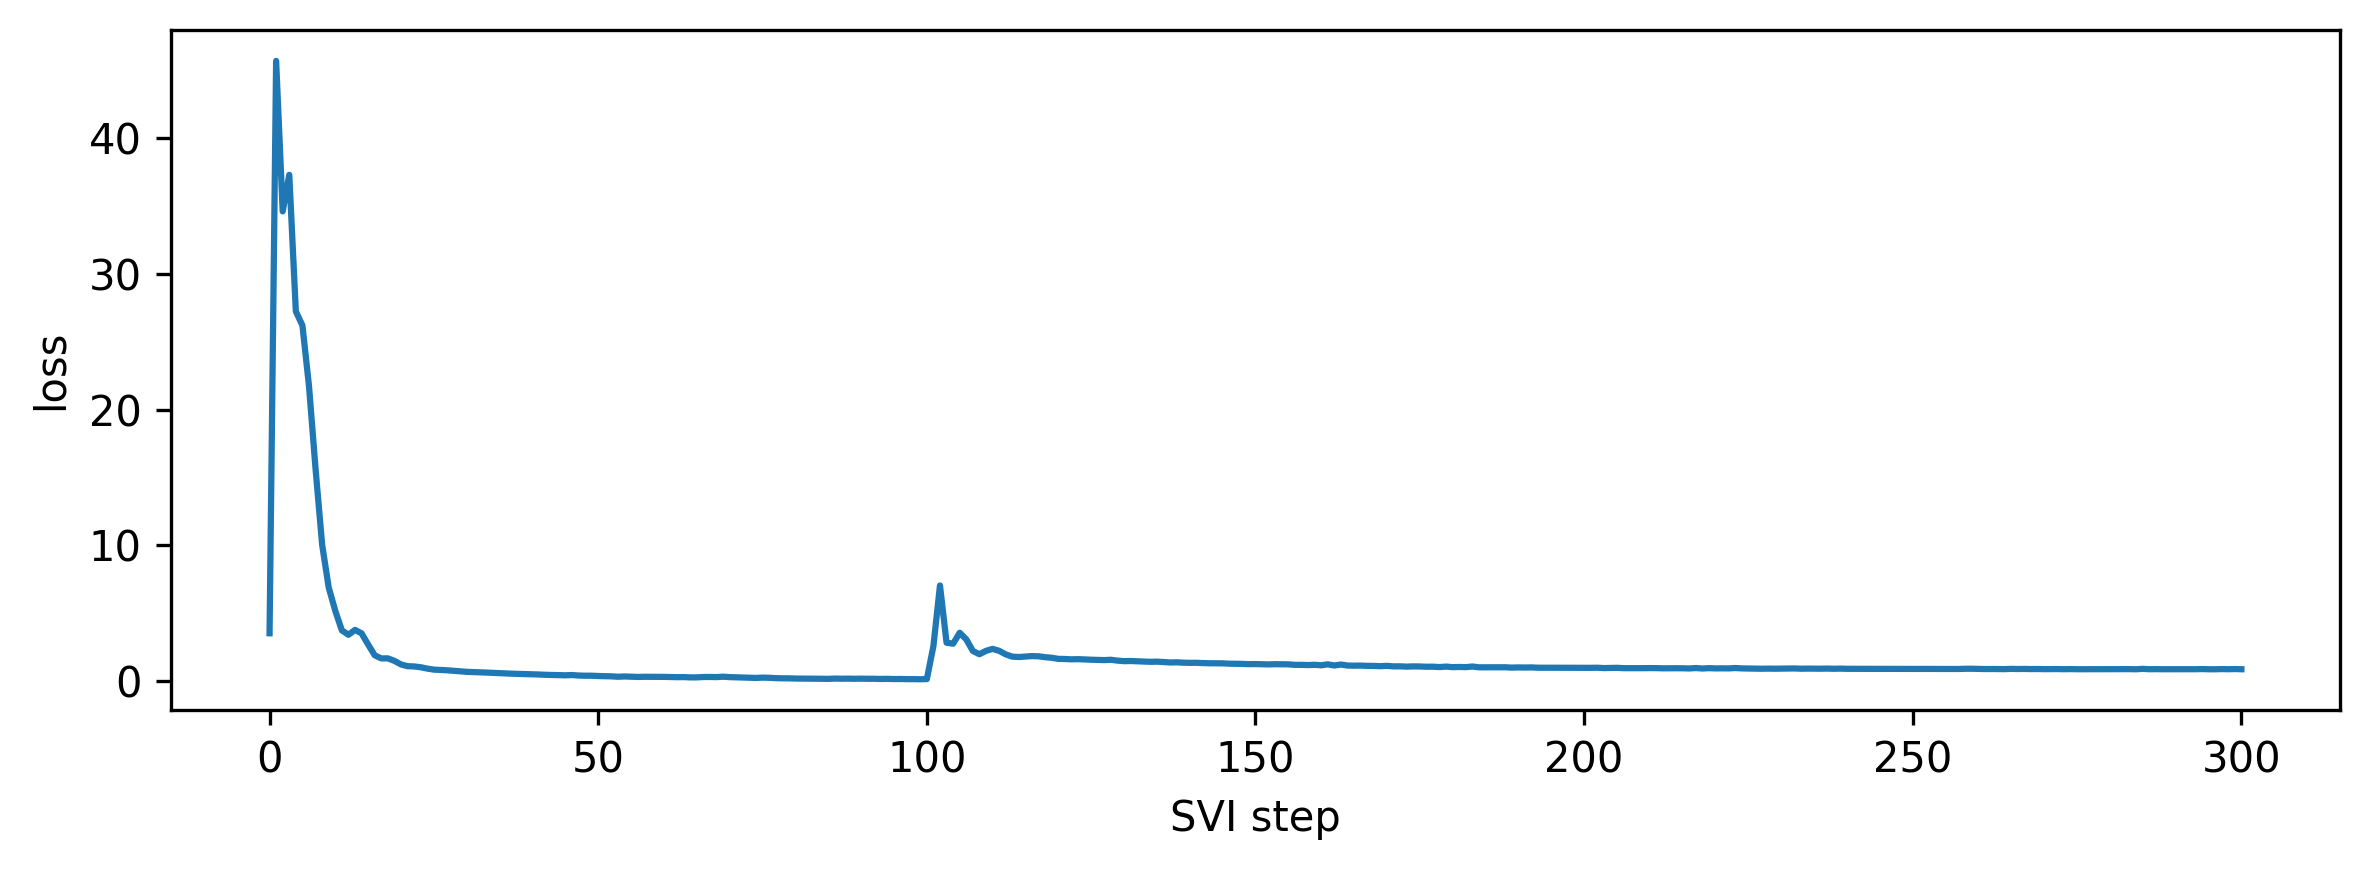

In [12]:
plt.figure(figsize=(8, 3), dpi=300)
plt.plot(results["losses"])
plt.ylabel("loss")
plt.xlabel("SVI step")
plt.tight_layout();

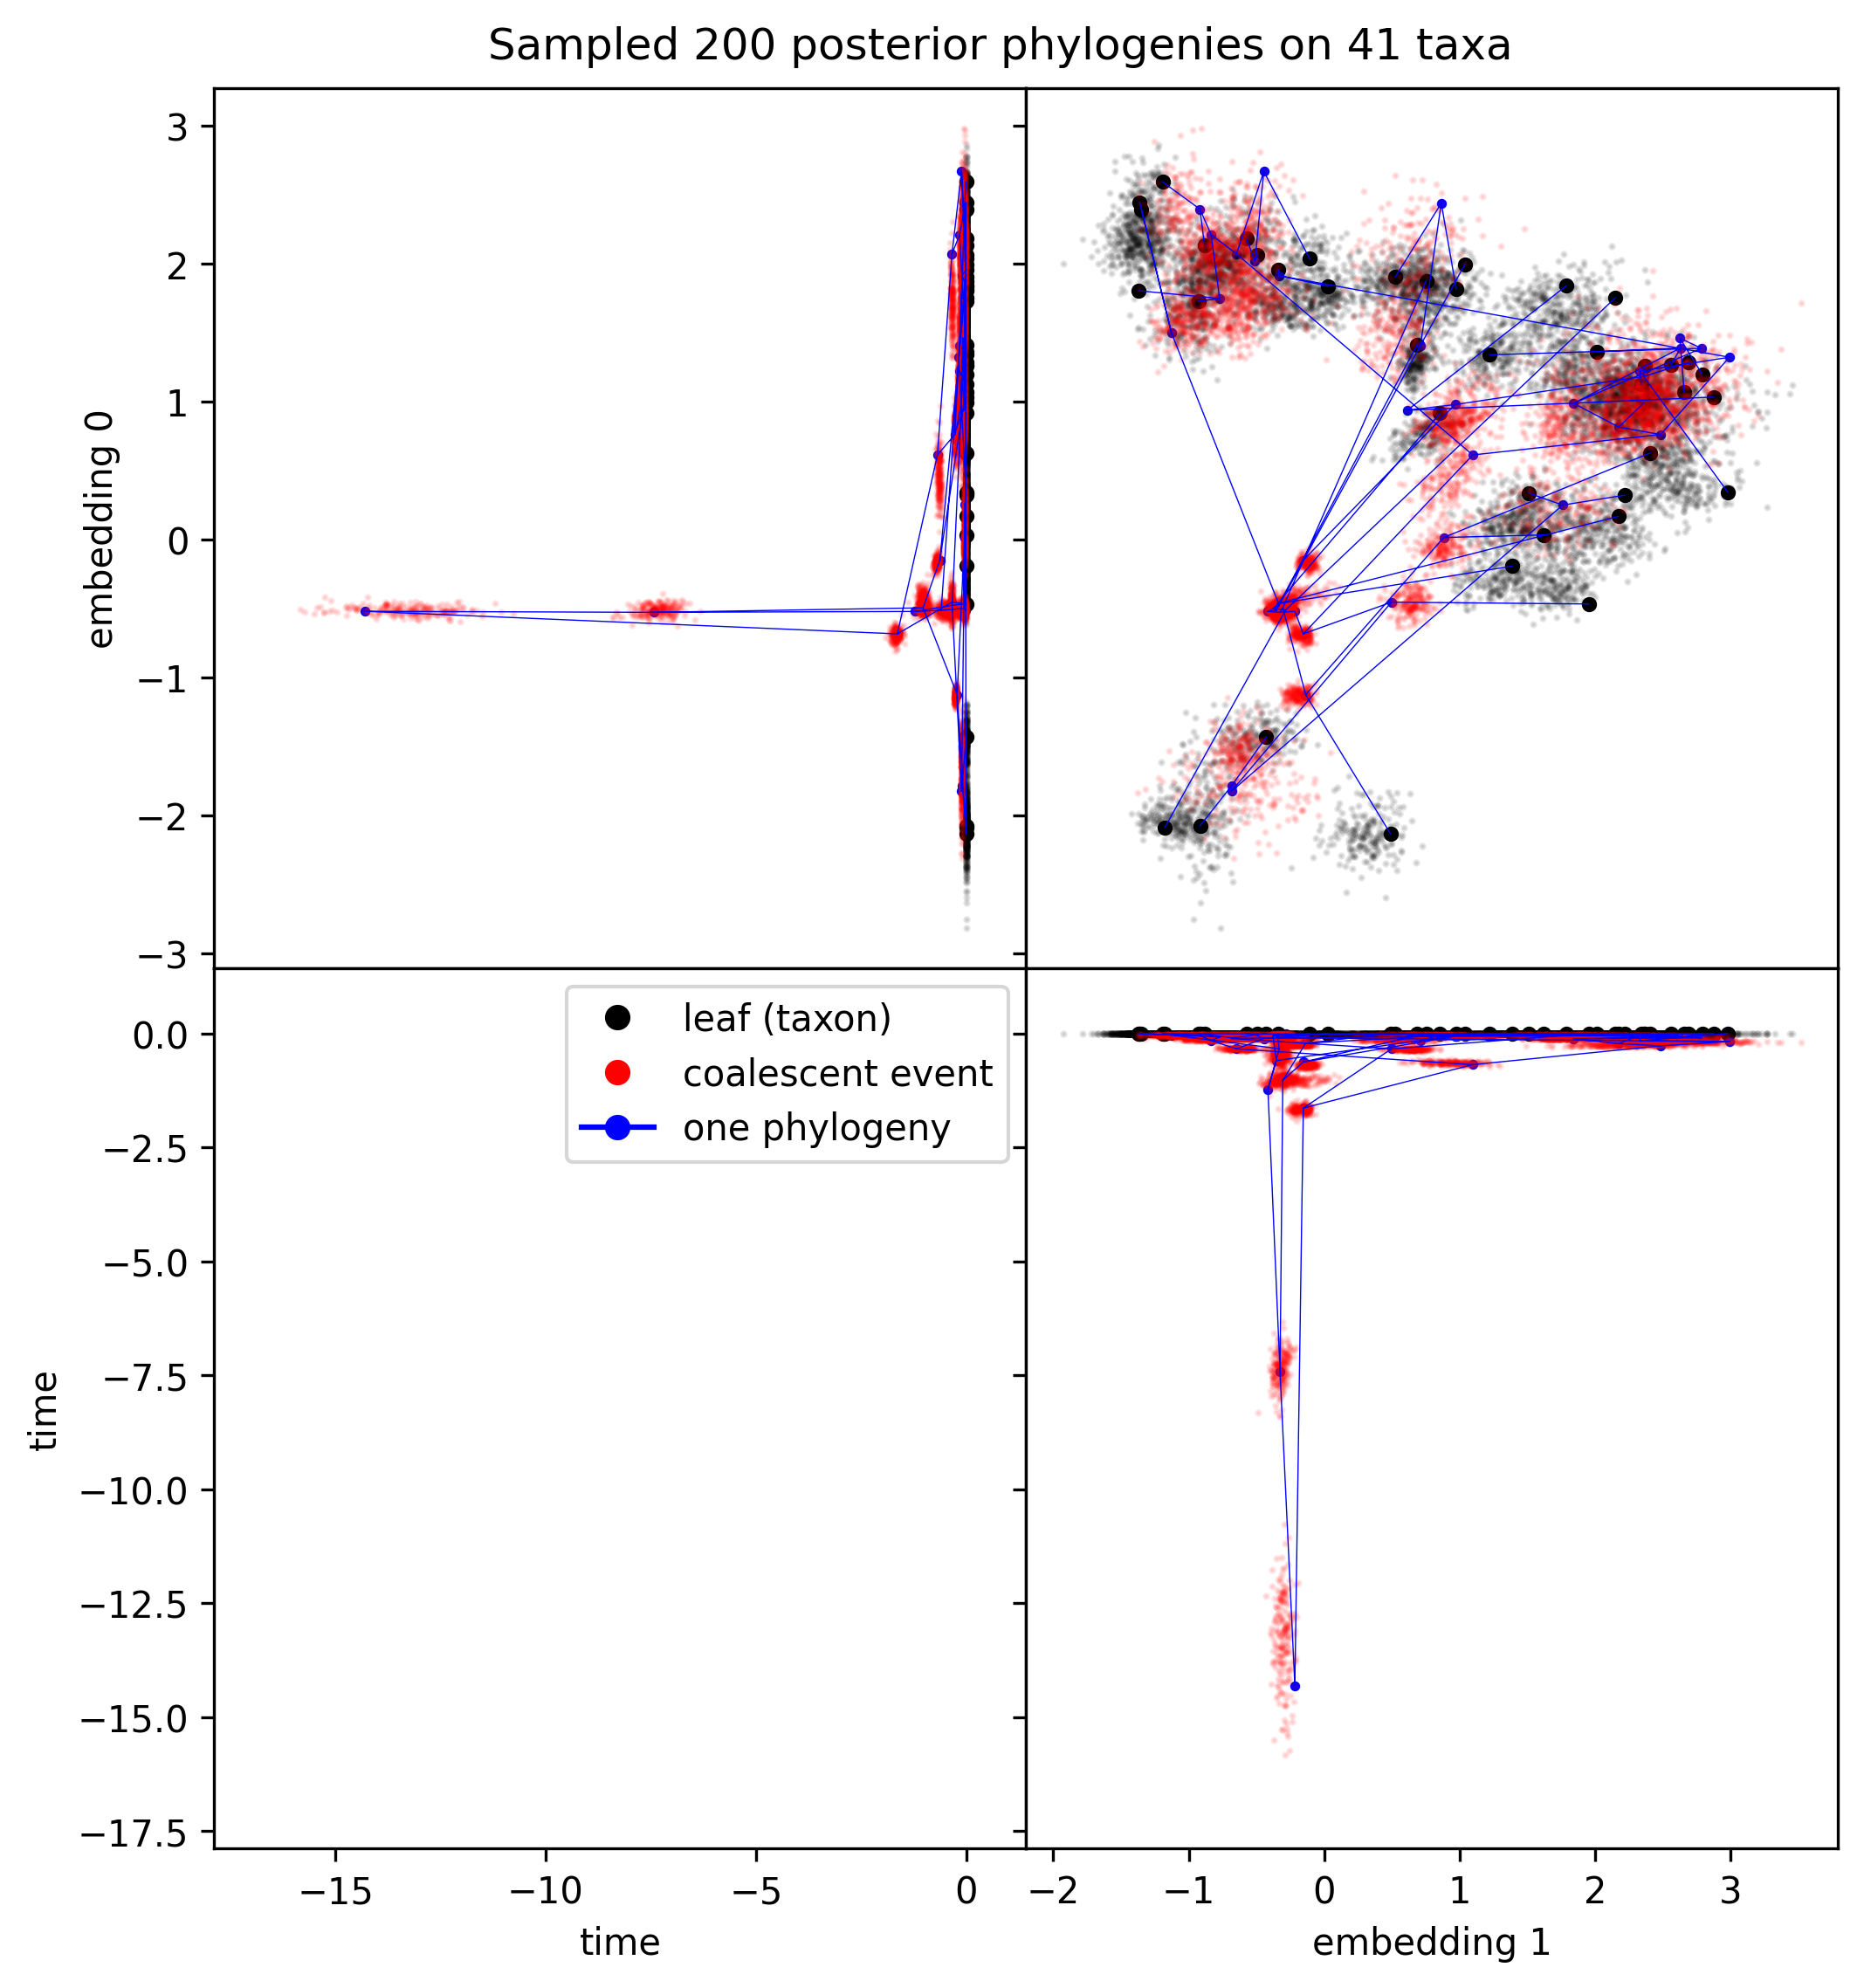

In [13]:
trees = samples["trees"]
codes = samples["codes"]
N, L = trees.num_nodes, trees.num_leaves
assert set(trees[0].leaves.tolist()) == set(range(N-L, N))
s = 0
tree = trees[s]
times, codex, codey = tree.times, codes[s, :, 0], codes[s, :, 1]

def plot(ax, X, Y):
    x, y = [], []
    for i, j in enumerate(tree.parents.tolist()):
        if j != -1:
            x.extend((X[i], X[j], None))
            y.extend((Y[i], Y[j], None))
    ax.plot(x, y, color="blue", markersize=3, lw=1/3, zorder=4, label="example tree")
    ax.scatter(X[:N-L], Y[:N-L], s=3, color="blue", zorder=1)
    ax.scatter(X[N-L:], Y[N-L:], s=10, color="black", zorder=0, label="leaf")

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex="col", sharey="row", dpi=300)
plot(axes[0][1], codey, codex)
plot(axes[0][0], times, codex)
plot(axes[1][1], codey, times)

# Plot distributions of codes.
alpha = 0.1
N, L = tree.num_nodes, tree.num_leaves
for span, color, zorder in [(slice(0, N-L), "red", 3), (slice(N-L, N), "black", 2)]:
    times = trees.times[:, span].reshape(-1)
    codex = codes[:, span, 0].reshape(-1)
    codey = codes[:, span, 1].reshape(-1)
    options = dict(s=1, alpha=alpha, color=color, zorder=zorder)
    axes[0][1].scatter(codey, codex, **options)
    axes[0][0].scatter(times, codex, **options)
    axes[1][1].scatter(codey, times, **options)

lb, ub = trees[0].times.min(), trees[0].times.max()
pad = ub - lb
lb, ub = lb - 0.25 * pad, ub + 0.1 * pad
axes[0][0].set_xlim(lb, ub)
axes[1][1].set_ylim(lb, ub)
axes[0][0].set_ylabel("embedding 0")
axes[1][0].set_ylabel("time")
axes[1][0].set_xlabel("time")
axes[1][1].set_xlabel("embedding 1")
ax = axes[1][0]
ax.plot([], [], "ko", label="leaf (taxon)")
ax.plot([], [], "ro", label="coalescent event")
ax.plot([], [], "b-", marker="o", label="one phylogeny")
ax.legend(loc="best")
fig.suptitle(f"Sampled {len(trees)} posterior phylogenies on {L} taxa")
plt.subplots_adjust(hspace=0, wspace=0, top=0.95)

## Comparing with IQ-Tree

In [ ]:
from pyrophylo.io import stack_nexus_trees
ml_tree = stack_nexus_trees("data/treebase/M487.nex.timetree.nex")[0]
print(ml_tree.batch_shape)

In [ ]:
ml_codes = torch.zeros_like(codes[0])
leaves = set(ml_tree.leaves.tolist())
for v in range(N - 1, 0, -1):
    if v in leaves:
        ml_codes[v] = codes[0, v]
    ml_codes[ml_tree.parents[v]] += 0.5 * ml_codes[v]

In [ ]:
times, codex, codey = ml_tree.times, ml_codes[:, 0], ml_codes[:, 1]

def plot(ax, X, Y):
    x, y = [], []
    for i, j in enumerate(ml_tree.parents.tolist()):
        if j != -1:
            x.extend((X[i], X[j], None))
            y.extend((Y[i], Y[j], None))
    ax.plot(x, y, color="blue", markersize=3, lw=1/3, zorder=4, label="example tree")
    ax.scatter(X[:N-L], Y[:N-L], s=3, color="red", zorder=1)
    ax.scatter(X[N-L:], Y[N-L:], s=10, color="black", zorder=0, label="leaf")

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex="col", sharey="row", dpi=300)
plot(axes[0][1], codey, codex)
plot(axes[0][0], times, codex)
plot(axes[1][1], codey, times)

axes[0][0].set_ylabel("embedding 0")
axes[1][0].set_ylabel("time")
axes[1][0].set_xlabel("time")
axes[1][1].set_xlabel("embedding 1")
ax = axes[1][0]
ax.plot([], [], "ko", label="leaf (taxon)")
ax.plot([], [], "ro", label="coalescent event")
ax.plot([], [], "b-", label="ML phylogeny")
ax.legend(loc="best")
fig.suptitle(f"Maximum likelihood phylogeny on {L} taxa (from IQ-TREE)")
plt.subplots_adjust(hspace=0, wspace=0, top=0.95)